<a target="_blank" href="https://colab.research.google.com/drive/1TLVzSmVFoTH9LGc2IfC39bGJ60uBHklv?usp=sharing">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

## 🕷️ Extract Wired Science News with `langchain-scrapegraph` and `langgraph`

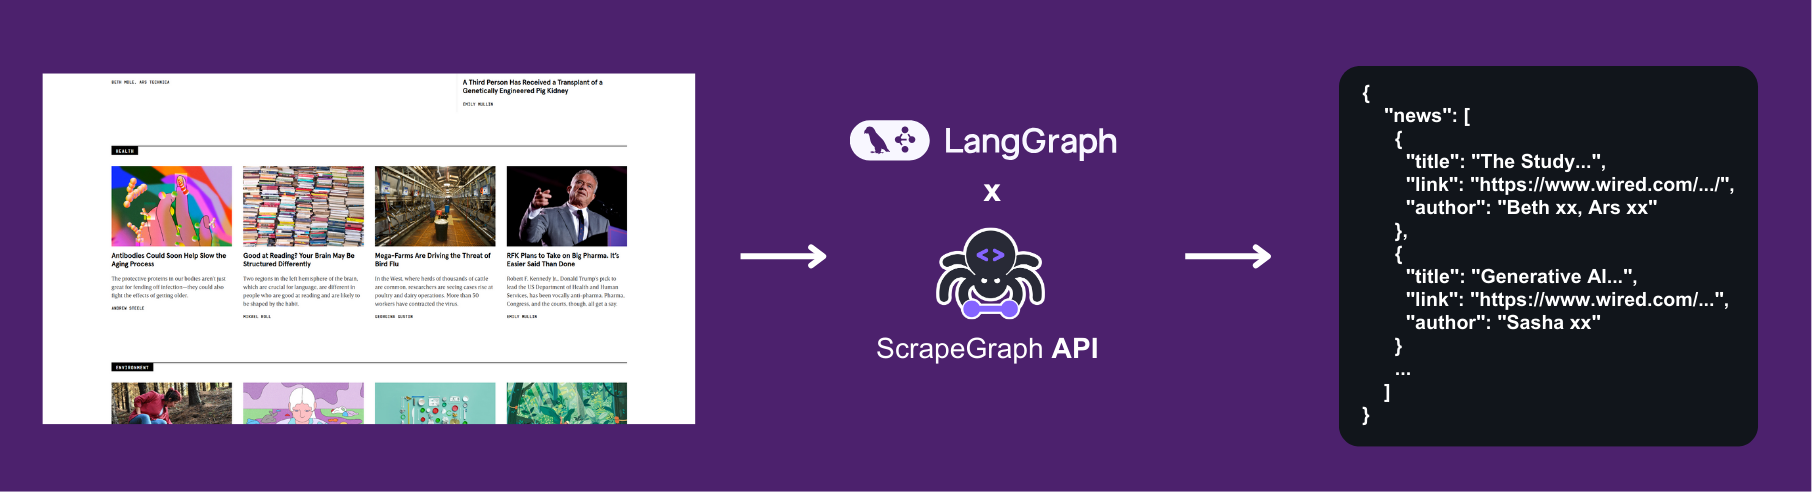

### 🔧 Install `dependencies`

In [1]:
%%capture
!pip install langgraph langchain-scrapegraph langchain-openai

### 🔑 Import `ScrapeGraph` and `OpenAI` API keys

You can find the Scrapegraph API key [here](https://dashboard.scrapegraphai.com/)

In [2]:
import getpass
import os

if not os.environ.get("SGAI_API_KEY"):
    os.environ["SGAI_API_KEY"] = getpass.getpass("Scrapegraph API key:\n")

if not os.environ.get("OPENAI_API_KEY"):
    os.environ["OPENAI_API_KEY"] = getpass.getpass("OpenAI API key:\n")

Scrapegraph API key:
··········
OpenAI API key:
··········


### 📝 Defining an `Output Schema` for Webpage Content Extraction


If you already know what you want to extract from a webpage, you can **define an output schema** using **Pydantic**. This schema acts as a "blueprint" that tells the AI how to structure the response.

<details>
  <summary>Pydantic Schema Quick Guide</summary>

Types of Schemas  

1. Simple Schema  
Use this when you want to extract straightforward information, such as a single piece of content.  

```python
from pydantic import BaseModel, Field

# Simple schema for a single webpage
class PageInfoSchema(BaseModel):
    title: str = Field(description="The title of the webpage")
    description: str = Field(description="The description of the webpage")

# Example Output JSON after AI extraction
{
    "title": "ScrapeGraphAI: The Best Content Extraction Tool",
    "description": "ScrapeGraphAI provides powerful tools for structured content extraction from websites."
}
```

2. Complex Schema (Nested)  
If you need to extract structured information with multiple related items (like a list of repositories), you can **nest schemas**.

```python
from pydantic import BaseModel, Field
from typing import List

# Define a schema for a single repository
class RepositorySchema(BaseModel):
    name: str = Field(description="Name of the repository (e.g., 'owner/repo')")
    description: str = Field(description="Description of the repository")
    stars: int = Field(description="Star count of the repository")
    forks: int = Field(description="Fork count of the repository")
    today_stars: int = Field(description="Stars gained today")
    language: str = Field(description="Programming language used")

# Define a schema for a list of repositories
class ListRepositoriesSchema(BaseModel):
    repositories: List[RepositorySchema] = Field(description="List of GitHub trending repositories")

# Example Output JSON after AI extraction
{
    "repositories": [
        {
            "name": "google-gemini/cookbook",
            "description": "Examples and guides for using the Gemini API",
            "stars": 8036,
            "forks": 1001,
            "today_stars": 649,
            "language": "Jupyter Notebook"
        },
        {
            "name": "TEN-framework/TEN-Agent",
            "description": "TEN Agent is a conversational AI powered by TEN, integrating Gemini 2.0 Multimodal Live API, OpenAI Realtime API, RTC, and more.",
            "stars": 3224,
            "forks": 311,
            "today_stars": 361,
            "language": "Python"
        }
    ]
}
```

Key Takeaways  
- **Simple Schema**: Perfect for small, straightforward extractions.  
- **Complex Schema**: Use nesting to extract lists or structured data, like "a list of repositories."  

Both approaches give the AI a clear structure to follow, ensuring that the extracted content matches exactly what you need.
</details>


In [71]:
from pydantic import BaseModel, Field
from typing import List

# Schema for a single news item
class NewsItemSchema(BaseModel):
    title: str = Field(description="Title of the news article")
    link: str = Field(description="URL to the news article")
    author: str = Field(description="Author of the news article")

# Schema that contains a list of news items
class ListNewsSchema(BaseModel):
    news: List[NewsItemSchema] = Field(description="List of news articles with their details")

### 🚀 Initialize `langchain-scrapegraph` tools and `langgraph` prebuilt agent and run the `extraction`

Here we use `SmartScraperTool` to extract structured data using AI from a webpage.


> If you already have an HTML file, you can upload it and use `LocalScraperTool` instead.

You can find more info in the [official langchain documentation](https://python.langchain.com/docs/integrations/tools/scrapegraph/)



In [ ]:
from llama_index.tools.scrapegraph.base import ScrapegraphToolSpec
from pydantic import BaseModel, Field
from typing import List
import os

# Initialize the ScrapegraphToolSpec
scrapegraph_tool = ScrapegraphToolSpec()

# Schema for a single news item
class NewsItemSchema(BaseModel):
    category: str = Field(description="Category of the news (e.g., 'Health', 'Environment')")
    title: str = Field(description="Title of the news article")
    link: str = Field(description="URL to the news article")
    author: str = Field(description="Author of the news article")

# Schema containing a list of news items
class ListNewsSchema(BaseModel):
    news: List[NewsItemSchema] = Field(description="List of news articles with their details")

# Make the API call to scrape news articles
response = scrapegraph_tool.scrapegraph_smartscraper(
    prompt="Extract information about science news articles",
    url="https://www.wired.com/tag/science/",
    api_key="sgai-cd497c94-9ac5-4259-b7b5-f3283affe481",
    schema=ListNewsSchema,
)

# Get the result and print each news article
result = response["result"]
print("\nWired Science News Articles:")
for article in result["news"]:
    print(f"\nCategory: {article['category']}")
    print(f"Title: {article['title']}")
    print(f"Author: {article['author']}")
    print(f"Link: {article['link']}")

# Save to CSV (optional)
import pandas as pd
df = pd.DataFrame(result["news"])
df.to_csv("wired_news.csv", index=False)
print("\nData saved to wired_news.csv")


In [72]:
from llama_index.tools.scrapegraph.base import ScrapegraphToolSpec
# Will automatically get SGAI_API_KEY from environment
# Initialization without output schema
# tool = SmartScraperTool()

# Since we have defined an output schema, let's use it
# This will force the tool to have always the same output structure
scrapegraph_tool = ScrapegraphToolSpec()

We then initialize the `llm model` we want to use in the agent



In [12]:
# Make the API call to scrape news articles
response = scrapegraph_tool.scrapegraph_smartscraper(
    prompt="Extract information about science news articles",
    url="https://www.wired.com/tag/science/",
    api_key="sgai-cd497c94-9ac5-4259-b7b5-f3283affe481",
    schema=ListNewsSchema,
)


Here we use `create_react_agent` to quickly use one of the prebuilt agents from `langgraph.prebuilt` module

You can find more info in the [official langgraph documentation](https://langchain-ai.github.io/langgraph/how-tos/create-react-agent/)



Print the response

In [90]:
import json

print("Science News:")
print(json.dumps(result, indent=2))

Science News:
{
  "news": [
    {
      "title": "December Wildfires Are Now a Thing",
      "link": "https://www.wired.com/story/december-wildfires-are-now-a-thing/",
      "author": "Kylie Mohr"
    },
    {
      "title": "How to Manage Food Anxiety Over the Holidays",
      "link": "https://www.wired.com/story/how-to-cope-with-food-anxiety-during-the-festive-season/",
      "author": "Alison Fixsen"
    },
    {
      "title": "A Spacecraft Is About to Fly Into the Sun\u2019s Atmosphere for the First Time",
      "link": "https://www.wired.com/story/parker-solar-probe-atmosphere/",
      "author": "Eric Berger, Ars Technica"
    },
    {
      "title": "To Improve Your Gut Microbiome, Spend More Time in Nature",
      "link": "https://www.wired.com/story/to-improve-your-gut-microbiome-spend-more-time-in-nature-kathy-willis/",
      "author": "Kathy Willis"
    },
    {
      "title": "This Tropical Virus Is Spreading Out of the Amazon to the US and Europe",
      "link": "https://w

### 💾 Save the output to a `CSV` file

Let's create a pandas dataframe and show the table with the extracted content

In [91]:
import pandas as pd

# Convert dictionary to DataFrame
df = pd.DataFrame(result["news"])
df

,title,link,author
0,December Wildfires Are Now a Thing,https://www.wired.com/story/december-wildfires...,Kylie Mohr
1,How to Manage Food Anxiety Over the Holidays,https://www.wired.com/story/how-to-cope-with-f...,Alison Fixsen
2,A Spacecraft Is About to Fly Into the Sun’s At...,https://www.wired.com/story/parker-solar-probe...,"Eric Berger, Ars Technica"
3,"To Improve Your Gut Microbiome, Spend More Tim...",https://www.wired.com/story/to-improve-your-gu...,Kathy Willis
4,This Tropical Virus Is Spreading Out of the Am...,https://www.wired.com/story/this-tropical-viru...,Geraldine Castro
5,CDC Confirms First US Case of Severe Bird Flu,https://www.wired.com/story/cdc-confirms-first...,Emily Mullin
6,The Study That Called Out Black Plastic Utensi...,https://www.wired.com/story/black-plastic-uten...,"Beth Mole, Ars Technica"
7,How Christmas Trees Could Become a Source of L...,https://www.wired.com/story/how-christmas-tree...,Alexa Phillips
8,Creating a Global Package to Solve the Problem...,https://www.wired.com/story/global-plastics-tr...,Susan Solomon
9,These 3 Things Are Standing in the Way of a Gl...,https://www.wired.com/story/these-3-things-are...,Steve Fletcher and Samuel Winton


Save it to CSV

In [92]:
# Save the DataFrame to a CSV file
csv_file = "wired_news.csv"
df.to_csv(csv_file, index=False)
print(f"Data saved to {csv_file}")

Data saved to wired_news.csv


## 🔗 Resources


<p align="left">
  <img src="https://raw.githubusercontent.com/VinciGit00/Scrapegraph-ai/main/docs/assets/api-banner.png"
       alt="ScrapeGraph API Banner" width="600">
</p>


- 🚀 **Get your API Key:** [ScrapeGraphAI Dashboard](https://dashboard.scrapegraphai.com)  
- 🐙 **GitHub:** [ScrapeGraphAI GitHub](https://github.com/scrapegraphai)  
- 💼 **LinkedIn:** [ScrapeGraphAI LinkedIn](https://www.linkedin.com/company/scrapegraphai/)  
- 🐦 **Twitter:** [ScrapeGraphAI Twitter](https://twitter.com/scrapegraphai)  
- 💬 **Discord:** [Join our Discord Community](https://discord.gg/uJN7TYcpNa)  
- 🦜 **Langchain:** [ScrapeGraph docs](https://python.langchain.com/docs/integrations/tools/scrapegraph/)

Made with ❤️ by the [ScrapeGraphAI](https://scrapegraphai.com) Team  
